<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/reviews_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/karencfisher/hotel-reviews/main/data/reviews_sample.csv

--2023-02-13 19:46:50--  https://raw.githubusercontent.com/karencfisher/hotel-reviews/main/data/reviews_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23866047 (23M) [text/plain]
Saving to: ‘reviews_sample.csv’

reviews_sample.csv  100%[===================>]  22.76M  --.-KB/s    in 0.1s    

2023-02-13 19:46:51 (165 MB/s) - ‘reviews_sample.csv’ saved [23866047/23866047]



In [2]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

The data set is one I have sampled from a much larger data set of over 1 million hotel reviews from around the world. I have cleaned the text here, removing stop words and converting to all lower case. 

The original data set included several ratings, 1 to 5 stars, including cleanliness, service, location, etc., as well as an overall rating. I averaged those for each review and binned the results into binary sentiment: 0 bad, 1 good. The model then classifies reviews in that regard.

In [4]:
data_path = 'reviews_sample.csv'
df_reviews = pd.read_csv(data_path)

df_reviews.sample(10)

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Content,average_score,sentiment
2117,1,5,1,1,3,1,3,disgusting one nastiest hotels ive ever slept ...,2.142857,0
11404,2,5,3,2,3,4,5,good value maui hawaii booked stay papakea dir...,3.428571,0
29917,5,5,5,5,5,5,5,special hotel stayed orlando 12 nights flying ...,5.000000,1
11355,3,3,1,1,1,1,1,humiliated robbed stayed accomodation 2 nights...,1.571429,0
26539,4,4,5,4,4,4,4,wished stayed longer spent last 6 days trip go...,4.142857,1
9411,4,4,3,4,3,3,3,good budget traveller another hotel required m...,3.428571,0
31350,2,4,3,3,3,5,5,great rate location booked priceline 7000 wedn...,3.571429,1
282,4,4,3,2,4,1,3,great decor terrible noise course hard rock ho...,3.000000,0
31187,4,5,4,4,3,5,4,great price great location second stay haciend...,4.142857,1
21246,4,5,5,4,5,5,5,great 2day stay radisson martinique family 5 t...,4.714286,1


Train test split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_reviews['Content'],
                                                    df_reviews['sentiment'],
                                                    test_size=0.1)
x_train.shape, y_test.shape

((31609,), (3513,))

Tokenizing the reviews. The tokenizer is trained on the training dataset only; it is applied to both. If there is an unknown word in the test data, it will be replaced with a special token '<OOV>' -- meaning "Out Of Vocabulary." We also limited the vocabularly to the top 10000 words. Other words will be renedered as '<OOV>'. They tend to be more rarely used words.

The tokenizer also converts the individual tokens to integers, which are indexes of the words in the vocabularly. 

The next step then is to pad the reviews so as to be of all the same length. This is because the input dimension to the neural network is of fixed length. The individual reviews are padded at the end to be of the same length as the longest review.


In [6]:
vocab_size = 10000
embed_dim = 64
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_text = tokenizer.texts_to_sequences(x_train)
x_train_text = pad_sequences(x_train_text, padding='post')

x_test_text = tokenizer.texts_to_sequences(x_test)
x_test_text = pad_sequences(x_test_text, padding='post')


Construct the Bidirectional LSTM network. The final classification is performed after the LSTM layer with a fully connected layer. It has the following layers:



1.   Embedding layer. Translates the tokens into word vectors (64 values).
2.   BiDirectional LSTM layer
3.   Hidden dense layer with 64 neurons and Relu activation function.
4    Output layer of single neuron with Sigmoid activation. It returns 0 to 1:
     If > .5 is a positive review, otherwise negative.





In [8]:
model = Sequential([Embedding(vocab_size, embed_dim, mask_zero=True),
                    Bidirectional(LSTM(embed_dim, dropout=0.20)),
                    Dense(1, activation='sigmoid')])

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 706,177
Trainable params: 706,177
Non-trainable params: 0
_________________________________________________________________


Train the model. 

In [9]:
stopping = EarlyStopping(monitor='val_accuracy', 
                         patience=3, 
                         restore_best_weights=True)

history = model.fit(x_train_text, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_text, y_test),
                    callbacks=[stopping])

Epoch 1/30
988/988 [==============================] - 136s 124ms/step - loss: 0.6915 - accuracy: 0.6017 - val_loss: 0.6894 - val_accuracy: 0.6732
Epoch 2/30
988/988 [==============================] - 58s 59ms/step - loss: 0.6570 - accuracy: 0.7442 - val_loss: 0.5583 - val_accuracy: 0.7896
Epoch 3/30
988/988 [==============================] - 47s 48ms/step - loss: 0.4750 - accuracy: 0.8175 - val_loss: 0.4603 - val_accuracy: 0.8175
Epoch 4/30
988/988 [==============================] - 44s 45ms/step - loss: 0.4399 - accuracy: 0.8259 - val_loss: 0.4433 - val_accuracy: 0.8386
Epoch 5/30
988/988 [==============================] - 42s 42ms/step - loss: 0.4208 - accuracy: 0.8398 - val_loss: 0.4308 - val_accuracy: 0.8326
Epoch 6/30
988/988 [==============================] - 40s 40ms/step - loss: 0.4121 - accuracy: 0.8352 - val_loss: 0.4255 - val_accuracy: 0.8377
Epoch 7/30
988/988 [==============================] - 41s 41ms/step - loss: 0.4012 - accuracy: 0.8423 - val_loss: 0.4147 - val_accurac

Model evaluation. 

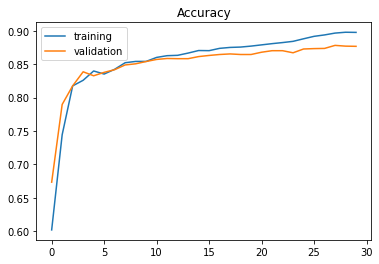

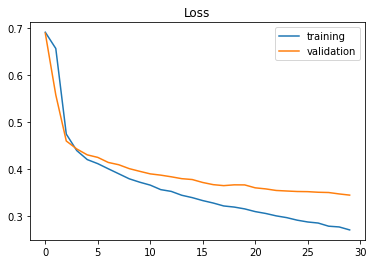

In [10]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label ='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label ='validation')
plt.legend()
plt.title('Loss')
plt.show()


In [11]:
pred_y = model.predict(x_test_text, verbose=1)
pred_y = pred_y > 0.5

110/110 [==============================] - 4s 12ms/step


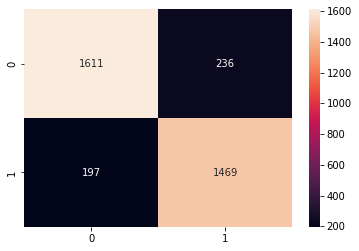

In [12]:
cf = confusion_matrix(pred_y, y_test)
sns.heatmap(cf, annot=True, fmt='d');

In [13]:
print(classification_report(pred_y, y_test, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      1847
    Positive       0.86      0.88      0.87      1666

    accuracy                           0.88      3513
   macro avg       0.88      0.88      0.88      3513
weighted avg       0.88      0.88      0.88      3513



Compare with baseline: the probability of being accurate if one randomly guesses one or zero for each example, which is 66.89%.